# Предсказание температуры стали

## Введение

`Задача проекта`  
Cоздать модель для предсказания температуры стали, для того чтобы оптимизировать производственные расходы и  уменьшить потребление электроэнергии на этапе обработки стали. 

`Краткое описание этапа обработки стали`  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).  


## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Знакомство с данными

Импорт необходимых библиотек

In [1]:
# !pip install xgboost
# !pip install imblearn
# !pip install feature_engine

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime


from sklearn.pipeline import Pipeline       
from imblearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

# Зададим параметр случайности
 

Загрузим данные

In [3]:
try:
    data_arc = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_arc_new.csv',
                          parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_bulk_new.csv')
    data_bulk_time = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_bulk_time_new.csv',
                                parse_dates=['Bulk ' + str(i) for i in range(1, 16)])
    data_gas = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_gas_new.csv')
    data_temp = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_temp_new.csv',
                           parse_dates=['Время замера'])
    data_wire = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_wire_new.csv')
    data_wire_time = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\Для правок\15 Финал\final_steel\data_wire_time_new.csv',
                                parse_dates=['Wire ' + str(i) for i in range(1, 10)])
except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv',
                          parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv',
                                parse_dates=['Bulk ' + str(i) for i in range(1, 16)])
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv',
                           parse_dates=['Время замера'])
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets//data_wire_time_new.csv',
                                parse_dates=['Wire ' + str(i) for i in range(1, 10)])

Посмотрим на загруженные данные

In [4]:
display('data_arc — данные об электродах', data_arc.head())
display('data_bulk — данные о подаче сыпучих материалов (объём)', data_bulk.head())
display('data_bulk_time — данные о подаче сыпучих материалов (время)', data_bulk_time.head())
display('data_gas — данные о продувке сплава газом', data_gas.head())
display('data_temp — результаты измерения температуры', data_temp.head())
display('data_wire — данные о проволочных материалах (объём)', data_wire.head())
display('data_wire_time — данные о проволочных материалах (время)', data_wire_time.head())

'data_arc — данные об электродах'

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


'data_bulk — данные о подаче сыпучих материалов (объём)'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


'data_bulk_time — данные о подаче сыпучих материалов (время)'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


'data_gas — данные о продувке сплава газом'

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


'data_temp — результаты измерения температуры'

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


'data_wire — данные о проволочных материалах (объём)'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'data_wire_time — данные о проволочных материалах (время)'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Для более удобного использования напишем функцию перевода названия столбцов к змеиному регистру

In [5]:
def snake_case(str):
    return ('_'.join(str.split())).lower()

In [6]:
data_arc.columns = [snake_case(i) for i in data_arc.columns]
data_bulk.columns = [snake_case(i) for i in data_bulk.columns]
data_bulk_time.columns = [snake_case(i) for i in data_bulk_time.columns]
data_gas.columns = [snake_case(i) for i in data_gas.columns]
data_temp.columns = [snake_case(i) for i in data_temp.columns]
data_wire.columns = [snake_case(i) for i in data_wire.columns]
data_wire_time.columns = [snake_case(i) for i in data_wire_time.columns]

Проверим преобразование

In [7]:
data_temp.columns

Index(['key', 'время_замера', 'температура'], dtype='object')

### data_arc — данные об электродах

In [8]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [10]:
data_arc.describe()

,key,активная_мощность,реактивная_мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [11]:
print('Всего уникальных key-значений (партий): ', data_arc.key.nunique())

Всего уникальных key-значений (партий):  3214


Посмотрим на графики распределения

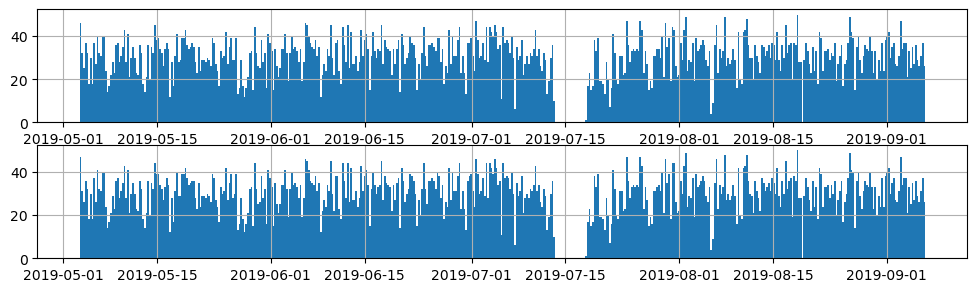

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(311)
data_arc['начало_нагрева_дугой'].hist(bins=500)
plt.subplot(312)
data_arc['конец_нагрева_дугой'].hist(bins=500);

Видно как в первой половине июля тех процесс стоял, возможно это был плановый ремонт какого либо оборудования.

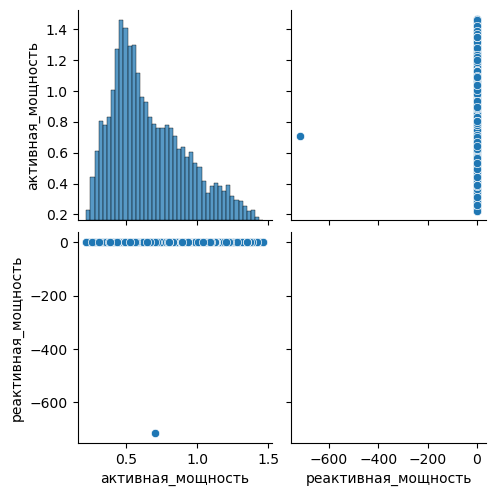

In [13]:
sns.pairplot(data_arc.drop('key', axis=1));

Видна аномальная реактивная мощность -715 при медиане 0.41.

In [14]:
data_arc[data_arc['реактивная_мощность'] < 0]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Видим одинокий выброс отрицательной реактивной мощности. Такая "большая" реактивная мощность при "небольшой, адекватной" активной мощности - это явный признак неправильного замера. 


Значит воспринимаем это как выброс и удалим эту партию.

In [15]:
data_arc = data_arc[data_arc['key'] != 2116]

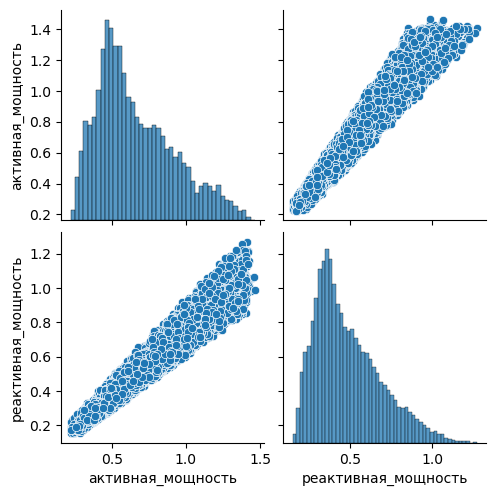

In [16]:
sns.pairplot(data_arc.drop('key', axis=1));

Реактивная мощность не выполняет полезной нагрузки. Она необходима для создания электромагнитного поля. Поэтому можно попробовать обойтись без нее, тем более модели не любят коррелирующих признаков. Посмотрим на косинус угла нагрузки, расчитанный по формуле $P/(\sqrt{P^2 + Q^2})$

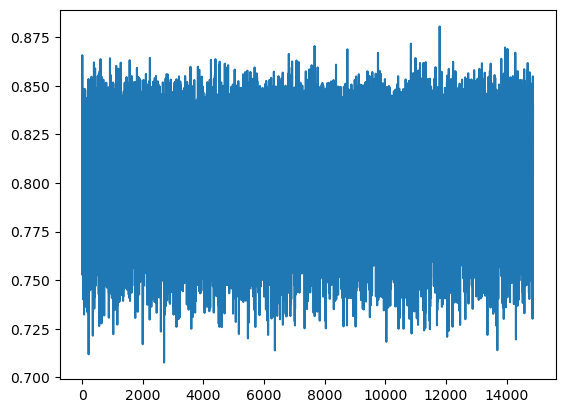

In [17]:
(data_arc['активная_мощность'] / np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)).plot();

Косинус угла нагрузки - отношение активной мощности к полной (корню суммы квадратов активной и реактивной). На графике он скачет от 0.72 до 0.85. Физически он показывает, какая часть полной мощности идет на совершение полезной работы (в нашем случае – на преобразование в тепло), а какая – на поддержание работоспособности самого устройства. Можно предположить что измерение мощности происходило, не непосредственно на нагревательной установке, а выше по сети (нагрузка неоднородна). Поэтому исключать реактивную составляющую не будем, а добавим в таблицу для модели расчетное значение полной мощности.

In [18]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

Добавим также признак - время нагрева и общая работа. Они будет коррелировать с мощностью. В дальнейшем будем выбирать нужные нам признаки, в том числе и по корреляции.

In [19]:
data_arc['общее_время_нагрева'] = (data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']).dt.seconds
data_arc['общая_работа'] = data_arc['общее_время_нагрева'] * data_arc['полная_мощность']

Посмотрим корреляцию

In [20]:
data_arc.drop('key', axis=1).corr()

,активная_мощность,реактивная_мощность,полная_мощность,общее_время_нагрева,общая_работа
активная_мощность,1.000000,0.966382,0.995528,0.010571,0.539122
реактивная_мощность,0.966382,1.000000,0.986334,0.006659,0.531304
полная_мощность,0.995528,0.986334,1.000000,0.009192,0.540471
общее_время_нагрева,0.010571,0.006659,0.009192,1.000000,0.789207
общая_работа,0.539122,0.531304,0.540471,0.789207,1.000000


Удалим данные столбцы с реактивной мощностью и временем окончания нагрева дугой

In [21]:
data_arc.drop(['реактивная_мощность', 'конец_нагрева_дугой'], axis=1, inplace=True)

Сгруппируем данные по номеру партии, и агрегируем данные

In [22]:
data_arc = data_arc.pivot_table(index='key', 
                     values=['начало_нагрева_дугой', 'активная_мощность', 'полная_мощность', 'общее_время_нагрева', 'общая_работа'],
                     aggfunc={'начало_нагрева_дугой': 'min', 'активная_мощность': 'sum', 'полная_мощность': 'sum',
                             'общее_время_нагрева': 'sum', 'общая_работа': 'sum'}
                    )

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>супер разобрался с мощностями!!! согласен.

Итоговая таблица

In [23]:
data_arc.head()

,активная_мощность,начало_нагрева_дугой,общая_работа,общее_время_нагрева,полная_мощность
key,,,,,
1,3.036730,2019-05-03 11:02:14,770.282114,1098,3.718736
2,2.139408,2019-05-03 11:34:14,481.760005,811,2.588349
3,4.063641,2019-05-03 12:06:54,722.837668,655,5.019223
4,2.706489,2019-05-03 12:39:37,683.455597,741,3.400038
5,2.252950,2019-05-03 13:11:13,512.169934,869,2.816980


Теперь наши основные статистики выглядят так

In [24]:
data_arc.describe()

,активная_мощность,общая_работа,общее_время_нагрева,полная_мощность
count,3213.000000,3213.000000,3213.000000,3213.000000
mean,3.067683,655.688884,794.691566,3.811201
std,1.208719,308.950188,332.439136,1.502848
min,0.267676,33.430208,57.000000,0.331897
25%,2.236693,444.864502,571.000000,2.775577
50%,2.984607,620.111140,770.000000,3.694535
75%,3.775574,827.784614,983.000000,4.697427
max,12.375636,4546.405812,4189.000000,15.288271


- data_arc содержит данные о времени нагрева и приложенной к этому мощности.
- Удалили партию с неадеватным выбросом в реактивной мощности.
- Добавили время нагрева в секундах.

### data_bulk, data_bulk_time — данные о подаче сыпучих материалов (объём, время)

In [25]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [26]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Посмотрим на распределение данных

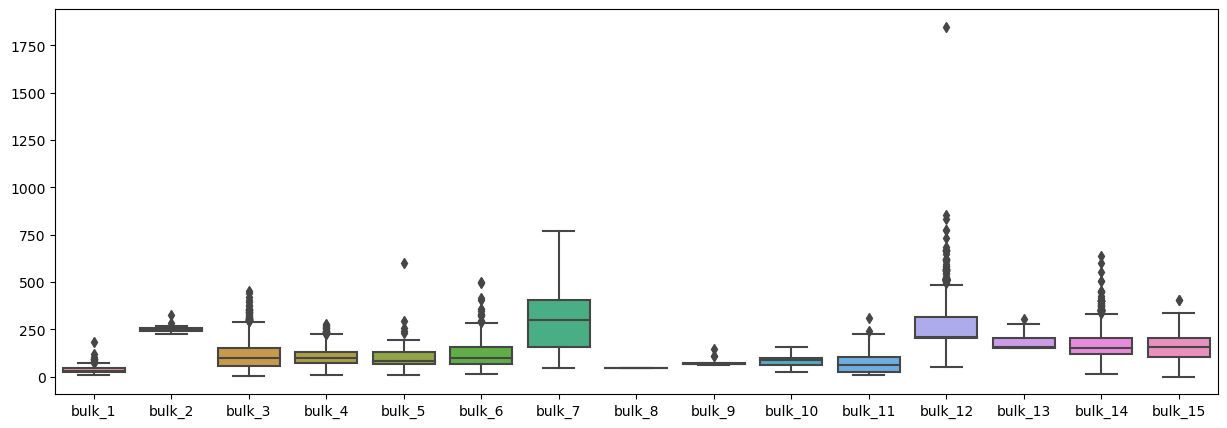

In [27]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk.drop('key', axis=1));

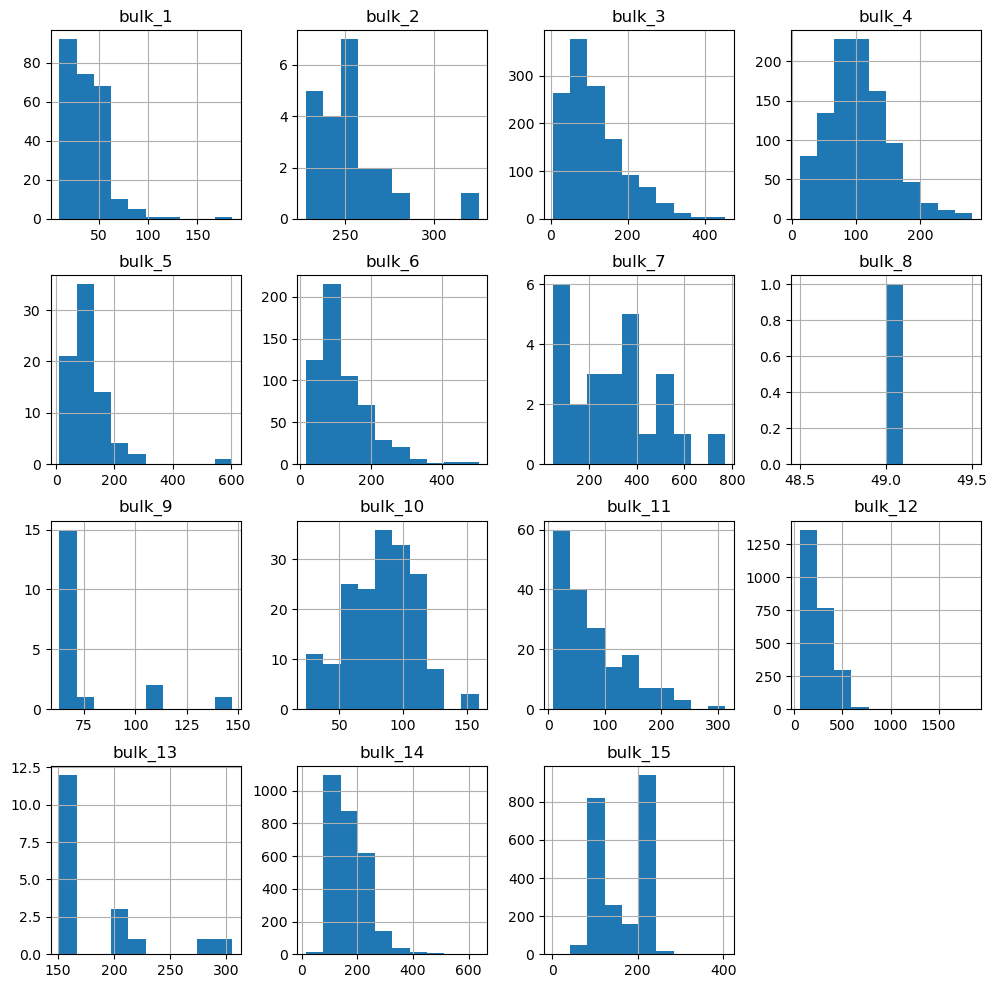

In [28]:
data_bulk.drop('key', axis=1).hist(figsize = (12,12));

In [29]:
data_bulk.drop('key', axis=1).describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Посмотрим на корреляцию

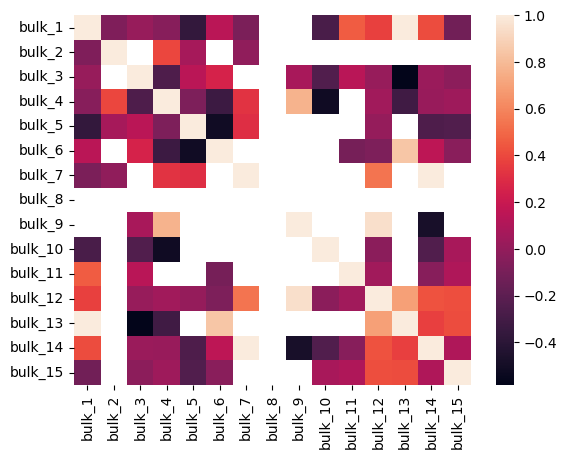

In [30]:
sns.heatmap(data_bulk.drop('key', axis=1).corr());
# Серый цвет - корреляции нет

In [31]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [32]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


- Размерности таблиц и количество пропусков в таблицах data_bulk_time и data_bulk совпадает. data_bulk - содержит количество сыпучих материалов добавленных для получения необходимых параметров металла, а data_bulk_time - время добавления.
- Данные достаточнно неоднородные. Некоторые значения встречаются только 1 раз (bulk_8). Типы данных соответствуют данным
- Пропуски говорят о том что конкретный порошок не добавлялся, можно заменить 0.
- Матрица получается разреженная и при стандартизации неоходимо проследить , чтобы 0 оставались 0. Т.е. применять MaxAbsScaler или MinMaxScaler (т.к. в данных только положительные значения).
- Есть признаки которые сильно коррелируют между собой. (Возможно некоторые из них исключаться в преварительной обработке)
- Временным данным пока не вижу применение

### data_wire, data_wire_time — данные о проволочных материалах (объём, время)

In [33]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [35]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [36]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


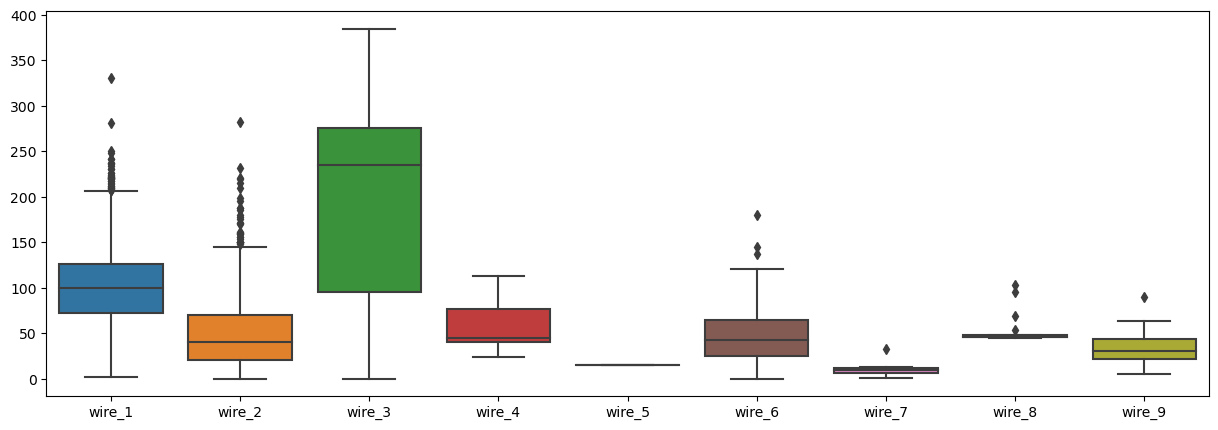

In [37]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire.drop('key', axis=1));

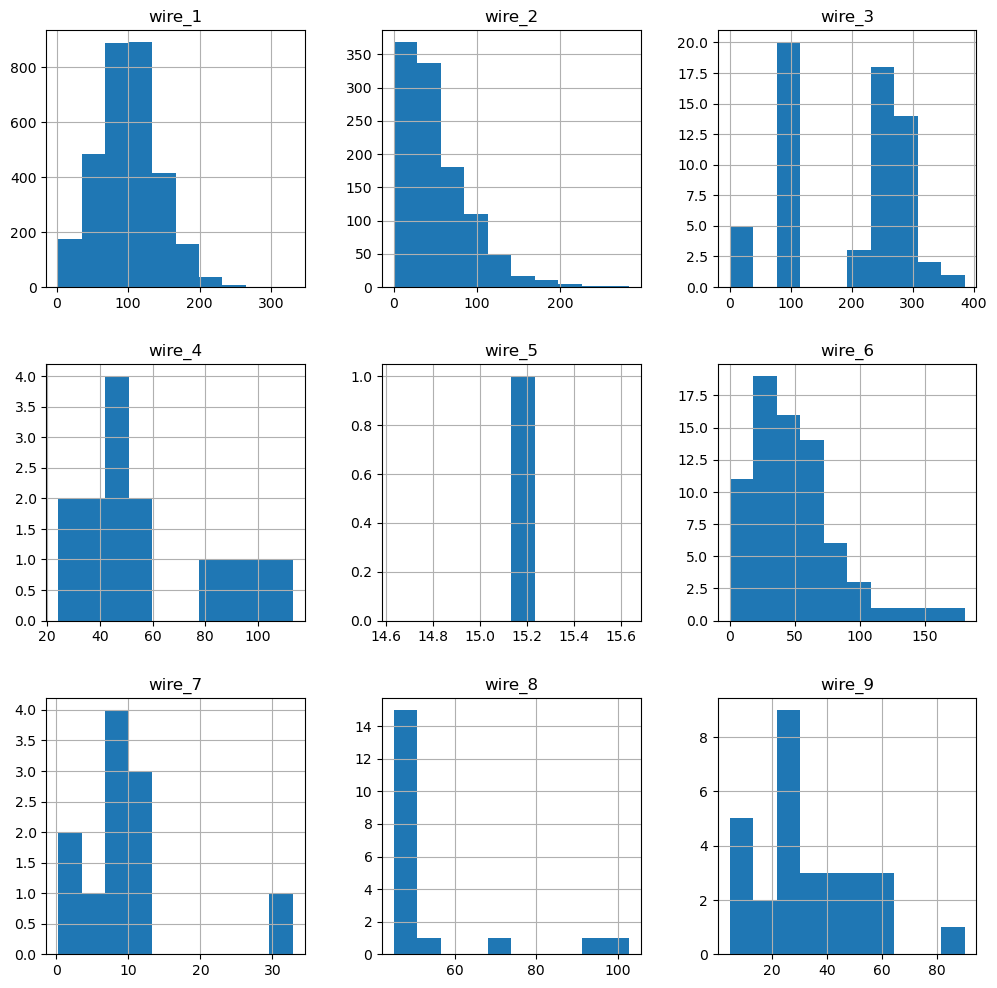

In [38]:
data_wire.drop('key', axis=1).hist(figsize = (12,12));

In [39]:
data_wire.drop('key', axis=1).describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Посмотрим на корреляцию

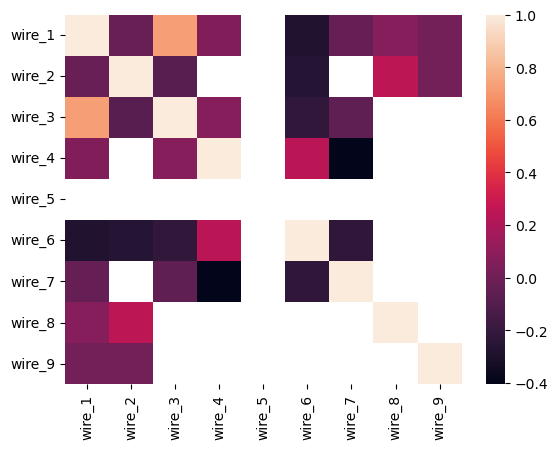

In [40]:
sns.heatmap(data_wire.drop('key', axis=1).corr());
# Серый цвет - корреляции нет

- Размерности таблиц и количество пропусков в таблицах data_wire_time и data_wire совпадает. data_wire - содержит количество проволочных материалов добавленных для получения необходимых параметров металла, а data_wire_time - время добавления.
- Данные достаточнно неоднородные. Некоторые значения встречаются только 1 раз (wire_5). Типы данных соответствуют данным
- Пропуски говорят о том что конкретный порошок не добавлялся, можно заменить 0.
- Матрица получается разреженная и при стандартизации неоходимо проследить , чтобы 0 оставались 0. Т.е. применять MaxAbsScaler или MinMaxScaler (т.к. в данных только положительные значения).
- Временным данным пока не вижу применение

### data_gas — данные о продувке сплава газом

In [41]:
data_gas.head()

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [42]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Посмотрим на распределение признака

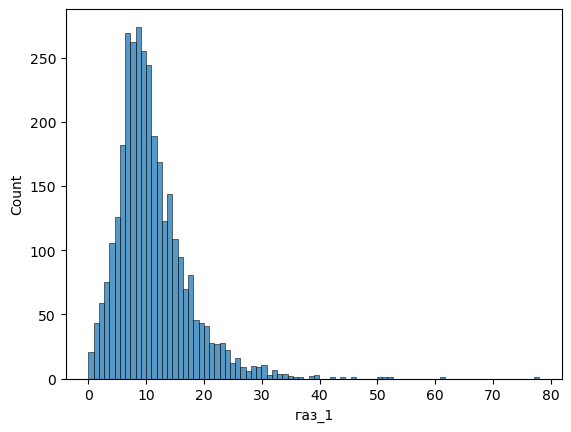

In [43]:
sns.histplot(data_gas['газ_1']);

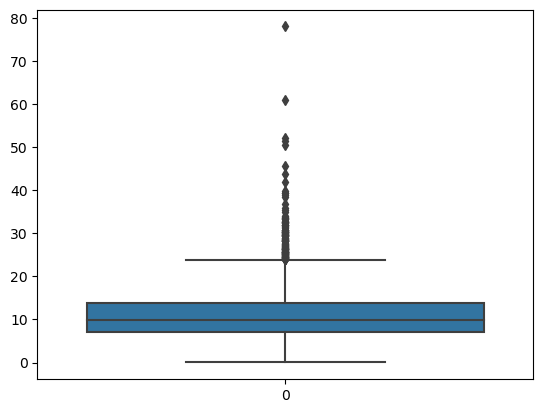

In [44]:
sns.boxplot(data=data_gas['газ_1']);

Посмотрим на значения газа более 50

In [45]:
temp = list(data_gas.query('газ_1 > 50')['key'])

In [46]:
data_arc.query("key in @temp")

,активная_мощность,начало_нагрева_дугой,общая_работа,общее_время_нагрева,полная_мощность
key,,,,,
117,4.191196,2019-05-07 21:50:53,619.135781,804,5.102765
280,4.248512,2019-05-14 11:12:55,1040.907729,1807,5.191116
322,8.914806,2019-05-15 21:12:28,2026.007227,2658,11.075555
2110,1.945132,2019-07-27 19:09:20,266.771323,547,2.429767
2570,5.330177,2019-08-13 10:22:38,788.885544,1104,6.606142


- data_gas - содержит информацию о количестве газа, затрачиваемого на перемешивание металла партии
- Есть значения кратно превышающее среднее. Видно что большой объем газа сопровождается и значиями мощности более среднего. Считаю что такие данные эти можно оставить, так как, к примеру, при нарушении технологического процесса нужно больше ресурсов для приготовления продукта, и такие данные помогут модели в будущем это учесть.

### data_temp — результаты измерения температуры

Ознакомимся с данными

In [47]:
data_temp.head()

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [48]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Посмотрим на распределение

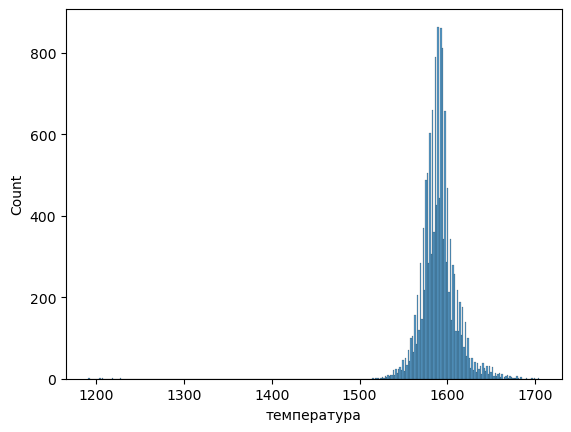

In [49]:
sns.histplot(data_temp['температура']);

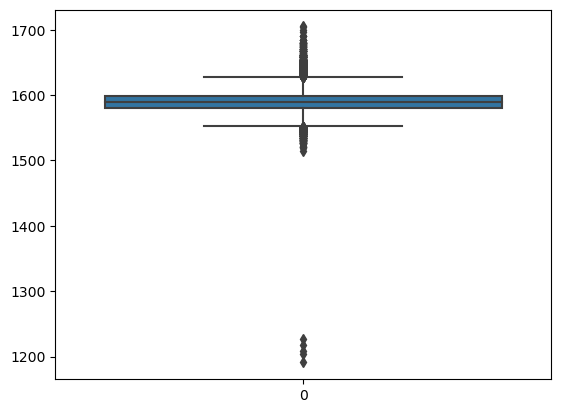

In [50]:
sns.boxplot(data=data_temp['температура']);

Видим выбивающиеся значения, с температурой ниже среднего. Температура - целевой признак. Считаю что нужно удалить данные (для улучшения качества модели в нужном нам диапазоне температур). Природа этих температур не понятна, скорее всего ошибка измерения. Сохраним ключи, по которым в последствии сможем найти их.

In [51]:
key_1450 = data_temp.query('температура < 1450')['key']

In [52]:
key_1450

4883      867
6784     1214
9050     1619
11495    2052
14283    2561
Name: key, dtype: int64

In [53]:
data_temp.query('key in @key_1450')

,key,время_замера,температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0


Да, скорее всего это ошибки замера. 1 температура партий имеет аномально низкое значение. Удалять будем партиями целиком.

In [54]:
data_temp = data_temp.query('key not in @key_1450')

Также посмотрим на пропуски

In [55]:
temp_key = data_temp[data_temp["температура"].isna()]["key"]
data_temp.query('key in @temp_key').head(30)

,key,время_замера,температура
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN


Видно, что пропуски в партии обычно присутствуют во вторичных замерах температуры. Тоесть из-за этого мы не сможем вычленить наше целевое значение из этих партий металла. А значит эти данные для нас бесполезны. Удалим эти данные.

In [56]:
data_temp = data_temp.query('key not in @temp_key')

Из таблицы data_temp возьмем первый замер в партии как параметр, а последний как целевое значение. Для этого сгруппируем данные по ключу.

In [57]:
# Отсортируем таблицу по времени замера
data_temp = data_temp.sort_values('время_замера')

# Сгруппируем таблицу, возьмем мин и мах значения времени замера и первый и последний замер температуры
data_temp = data_temp.pivot_table(index='key', 
                     values=['время_замера', 'температура'],
                     aggfunc={'время_замера': ['min', 'max'],
                              'температура': ['first', 'last']}
                    )
data_temp.columns = ['время_финального_замера', 'время_начального_замера', 'начальная_температура', 'финальная_температура']

data_temp.head()

,время_финального_замера,время_начального_замера,начальная_температура,финальная_температура
key,,,,
1,2019-05-03 11:30:38,2019-05-03 11:02:04,1571.0,1613.0
2,2019-05-03 11:55:09,2019-05-03 11:34:04,1581.0,1602.0
3,2019-05-03 12:35:57,2019-05-03 12:06:44,1596.0,1599.0
4,2019-05-03 12:59:47,2019-05-03 12:39:27,1601.0,1625.0
5,2019-05-03 13:36:39,2019-05-03 13:11:03,1576.0,1602.0


- В данных по температуре нашли и удалили выбросы с температурой < 1450. Считаю что нужно удалить данные (для улучшения качества модели в нужном нам диапазоне температур). Природа этих температур не понятна, скорее всего ошибка измерения.
- Удалили пропуски партиями. Пропуски в партии обычно присутствуют во вторичных замерах температуры. Тоесть из-за этого мы не сможем вычленить наше целевое значение из этих партий металла. А значит эти данные для нас бесполезны.
- Сгруппировали таблицу для возможности дальнейшего объединения признаков. Из таблицы data_temp взяли первый замер в партии как параметр, а последний как целевое значение.

## Подготовка данных для модели

Объединим данные в одной таблице. Чтобы итоговые данные были цельными, будем использовать метод объединения inner

In [58]:
final_data = data_arc.merge(data_gas, on='key', how='inner') \
                     .merge(data_bulk, on='key', how='inner') \
                     .merge(data_wire, on='key', how='inner') \
                     .merge(data_temp, on='key', how='inner')
final_data.head()

,key,активная_мощность,начало_нагрева_дугой,общая_работа,общее_время_нагрева,полная_мощность,газ_1,bulk_1,bulk_2,bulk_3,...,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,время_финального_замера,время_начального_замера,начальная_температура,финальная_температура
0,1,3.036730,2019-05-03 11:02:14,770.282114,1098,3.718736,29.749986,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:30:38,2019-05-03 11:02:04,1571.0,1613.0
1,2,2.139408,2019-05-03 11:34:14,481.760005,811,2.588349,12.555561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:55:09,2019-05-03 11:34:04,1581.0,1602.0
2,3,4.063641,2019-05-03 12:06:54,722.837668,655,5.019223,28.554793,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:35:57,2019-05-03 12:06:44,1596.0,1599.0
3,4,2.706489,2019-05-03 12:39:37,683.455597,741,3.400038,18.841219,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:59:47,2019-05-03 12:39:27,1601.0,1625.0
4,5,2.252950,2019-05-03 13:11:13,512.169934,869,2.816980,5.413692,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:36:39,2019-05-03 13:11:03,1576.0,1602.0


Оставим только числовые столбцы и удалим номер партии

In [59]:
final_data = final_data[final_data.select_dtypes('number').columns.tolist()]
final_data.drop('key', axis=1, inplace=True)

In [60]:
final_data.head()

,активная_мощность,общая_работа,общее_время_нагрева,полная_мощность,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,начальная_температура,финальная_температура
0,3.036730,770.282114,1098,3.718736,29.749986,NaN,NaN,NaN,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1571.0,1613.0
1,2.139408,481.760005,811,2.588349,12.555561,NaN,NaN,NaN,73.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1581.0,1602.0
2,4.063641,722.837668,655,5.019223,28.554793,NaN,NaN,NaN,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1596.0,1599.0
3,2.706489,683.455597,741,3.400038,18.841219,NaN,NaN,NaN,81.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1601.0,1625.0
4,2.252950,512.169934,869,2.816980,5.413692,NaN,NaN,NaN,78.0,NaN,...,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1576.0,1602.0


Разделим на тестовую и обучающую выбоки

In [61]:
X = final_data.drop('финальная_температура', axis=1)
y = final_data['финальная_температура']

Выделим тестовую выборку

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

print(f'Размер обучающей выборки {X_train.shape} {y_train.shape}, \
     \nтестовой {X_test.shape} {y_test.shape}')

Размер обучающей выборки (1743, 30) (1743,),      
тестовой (581, 30) (581,)


**План дальнейшей работы**:
- Создать пайплайн.Заменим пропуски wire и bulk нулями. 
- Так как в основном у нас числовые количественные признаки проведем стандартизацию (Матрица получается разреженная и при стандартизации неоходимо проследить , чтобы 0 оставались 0. Т.е. применять MaxAbsScaler или MinMaxScaler (т.к. в данных только положительные значения).
- Временные данные пока не вижу куда деть, скорее всего их удалю. Так как на практике не представляю, что время нам будет известно при применении модели.
- Проведем проверку на мультиколлинеарность DropCorrelatedFeatures.
- Обучим пару моделей
- Оценим важность признаков

**Вопросы** (Некоторые скорее всего 'риторические')
1. На основании каких данных мы будем прогнозировать температуру. Тоесть есть изначально ковш с металлом и начальной температурой, знаем ли мы на данном этапе весь перечень и обьем добавочных материалов для приготовления финального состава? Знаем ли мы время, когда мы будем добавлять эти материалы?
2. Где производится измерение мощности, непосредственно на фидере нагревательного элемента? Есть ли влияние на данную мощность других потребителей?
3. В данных есть выбросы. Например газ_1 = 80 или температура 1200. Это нарушение тех процесса? Нужно ли учить модель предсказывать такую температуру? (это приведет к потере качества модели)


1. Я удалил партии с низкой температурой, добавил новый признак мощность до пайплайна. Правильно ли я сделал, или лучше будет это все включать в пайплайн?

## Предобработка и обучение модели (Pipeline)

Выделим названия числовых столбцов

In [63]:
num_cols = X_train.select_dtypes('number').columns.tolist()
num_cols

['активная_мощность',
 'общая_работа',
 'общее_время_нагрева',
 'полная_мощность',
 'газ_1',
 'bulk_1',
 'bulk_2',
 'bulk_3',
 'bulk_4',
 'bulk_5',
 'bulk_6',
 'bulk_7',
 'bulk_8',
 'bulk_9',
 'bulk_10',
 'bulk_11',
 'bulk_12',
 'bulk_13',
 'bulk_14',
 'bulk_15',
 'wire_1',
 'wire_2',
 'wire_3',
 'wire_4',
 'wire_5',
 'wire_6',
 'wire_7',
 'wire_8',
 'wire_9',
 'начальная_температура']

In [64]:
print(f'Размеры обучающих признаков {X_train.shape}')

Размеры обучающих признаков (1743, 30)


Начнем создавать пайплайн

In [65]:
# Пайплайн для числовых столбцов
num_pipline = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0)),
                        ('scaler', MinMaxScaler()),
                        ('drop_correlations', DropCorrelatedFeatures())])

# Применение пайплайна выше к признакам/столбцам
columns_pipeline = ColumnTransformer([('num_cols', num_pipline, num_cols)],
                                      remainder='drop', n_jobs=-1,
                                       verbose_feature_names_out=False
                                    )

Добавим следущим шагом удаление дубликатов, и выбор наиболее важных k признаков

In [66]:
pipeline = make_pipeline(columns_pipeline, 
                         DropDuplicateFeatures(),
                         SelectKBest(score_func=mutual_info_regression))

Добавим последним шагом случайную модель

In [67]:
pipeline.steps.append(('clf', DummyRegressor()))

Изначальный порядок пайплайна выглядит так

In [68]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('drop_correlations',
                                                                   DropCorrelatedFeatures())]),
                                                  ['активная_мощность',
                                                   'общая_работа',
                                                   'общее_время_нагрева',
                                                   'полная_мощность', 'газ_1',
                                                   'bulk_1', 'bulk_2', 'bulk_3...
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'wire_1', 'wire_2', 'wire_3',
                                                   'wire_4', 'wire_5', 'wire_6',
                                                   'wire_7', 'wire_8', 'wire_9',
                                                   'начальная_температура'])],
                                   verbose_feature_names_out=False)),
                ('dropduplicatefeatures', DropDuplicateFeatures()),
                ('selectkbest',
                 SelectKBest(score_func=<function mutual_info_regression at 0x000001CF22849280>)),
                ('clf', DummyRegressor())])

Для нахождения лучшей модели применим метод поиска по сетке(params) наилучших параметров RandomizedSearchCV. Для поиска выберем 3 модели регрессии LogisticRegression, RandomForestRegressor и XGBRegressor, а также словарь параметров для подбора.

In [69]:
# Список параметров для подбора
params = [

    {
        'clf': [DummyRegressor()]
    },    
    


     {
        'clf': [Ridge(random_state=random_state)],
        'clf__solver':['svd', 'lsqr'],
        'clf__alpha': [1e-2, 1e-1, 1, 10],
        'clf__fit_intercept':[True, False],
        'selectkbest__k' : np.arange(15, X_train.shape[1], 3),
        'columntransformer__num_cols__drop_correlations__threshold': [0.9, 0.95]

     },    
    
    
    {
        'clf': [RandomForestRegressor(random_state=random_state)],
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [3, 5, 15],
        'clf__max_features': [None, 'sqrt', 5,],
        'selectkbest__k' : np.arange(15, X_train.shape[1], 3),
        'columntransformer__num_cols__scaler': [None, MaxAbsScaler()],
        'columntransformer__num_cols__drop_correlations__threshold': [0.9, 0.95]
    },


    
#   Кэтбуст считает чуть лучше но значительно дольше, поэтому закоментировал. Не знаю с чем связано. По началу считал быстро
#     {
#         'clf': [CatBoostRegressor(random_state=random_state, verbose=0)],
#         'clf__learning_rate': np.arange(0.05, 1, 0.1),
#         'clf__max_depth': np.arange(3, 20, 1),
#         'clf__n_estimators': np.arange(50, 500, 30),
#         'columntransformer__num_cols__scaler': [None, MaxAbsScaler()],
#         'columntransformer__num_cols__drop_correlations__threshold': np.arange(0.85, 0.98, 0.03),
#         'selectkbest__k' : np.arange(20, X_train.shape[1], 2)
#     },
    
    {
        'clf': [XGBRegressor(random_state=random_state, verbose=0)],
        'clf__learning_rate': np.arange(0.05, 0.2, 0.1),
        'clf__max_depth': np.arange(3, 5, 1),
        'clf__n_estimators': np.arange(200, 400, 40),
        'columntransformer__num_cols__scaler': [None, MaxAbsScaler()],
        'columntransformer__num_cols__drop_correlations__threshold': [0.9, 0.95],
        'selectkbest__k' : np.arange(15, X_train.shape[1], 3)
    },    

]


grid = RandomizedSearchCV(pipeline,
                    params,
                    n_iter=200,
                    cv=3,
                    verbose=0,
                    random_state=random_state,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
#                     error_score='raise'
                         )

Запустим подбор на обучающей выборке

In [70]:
%%time
grid.fit(X_train, y_train)

[01:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

CPU times: total: 5.81 s
Wall time: 3min 28s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num_cols',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler()),
                                                                                               ('drop_correlations',
                                                                                                DropCorrelatedFeatures())]),
                                                                               ['активная_мощность',
                                                                                'общая_работа',
                                                                                'общее_время_нагрева',
                                                                                'полная_мощность'...
                                                              random_state=240423, ...)],
                                         'clf__learning_rate': array([0.05, 0.15]),
                                         'clf__max_depth': array([3, 4]),
                                         'clf__n_estimators': array([200, 240, 280, 320, 360]),
                                         'columntransformer__num_cols__drop_correlations__threshold': [0.9,
                                                                                                       0.95],
                                         'columntransformer__num_cols__scaler': [None,
                                                                                 MaxAbsScaler()],
                                         'selectkbest__k': array([15, 18, 21, 24, 27])}],
                   random_state=240423, scoring='neg_mean_absolute_error')

Посмотрим на результаты

In [71]:
cv_results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
cv_results = cv_results[['rank_test_score', 'param_clf', 'mean_test_score', 'mean_fit_time', 'params']]
#выберем название модели из объекта модели
cv_results['param_clf'] = cv_results['param_clf'].apply(lambda x: type(x).__name__)

cv_results = cv_results.pivot_table(index='param_clf',
                                     values=['mean_test_score'],
                                     aggfunc={'mean_test_score': 'max'}
                                    )
cv_results.columns = ['Лучшая МАЕ']
cv_results.sort_values('Лучшая МАЕ', ascending=False)

,Лучшая МАЕ
param_clf,
XGBRegressor,-6.237166
Ridge,-6.361278
RandomForestRegressor,-6.439824


Лучшая **MAE на обучающих** данных

In [72]:
grid.best_score_

-6.237166089021263

Параметры лучшей модели

In [73]:
grid.best_params_

{'selectkbest__k': 21,
 'columntransformer__num_cols__scaler': MaxAbsScaler(),
 'columntransformer__num_cols__drop_correlations__threshold': 0.95,
 'clf__n_estimators': 200,
 'clf__max_depth': 4,
 'clf__learning_rate': 0.05,
 'clf': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=240423, ...)}

Порядок обработки и обучения

In [74]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MaxAbsScaler()),
                                                                  ('drop_correlations',
                                                                   DropCorrelatedFeatures(threshold=0.95))]),
                                                  ['активная_мощность',
                                                   'общая_работа',
                                                   'общее_время_нагрева',
                                                   'полная_мощность', 'газ_1',
                                                   'bulk_1', 'b...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=240423, ...))])

### Тестирование лучшей модели

Метрика **МАЕ на тестовой** выборке

In [75]:
print(f'MAE: {mean_absolute_error(y_test, grid.predict(X_test))}')

MAE: 5.880850130432444


Список признаков на входе в модель

In [76]:
grid.best_estimator_[0].get_feature_names_out()[grid.best_estimator_[-2].get_support()]

array(['активная_мощность', 'общая_работа', 'общее_время_нагрева',
       'газ_1', 'bulk_1', 'bulk_2', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_12', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9',
       'начальная_температура'], dtype='<U21')

Построим графики важности признаков на целевую для лучшей модели. Слева у нас будут признаки оставшиеся после предобработки. Справа будут все признаки тестовой выборки + метод перемешивание признаков.

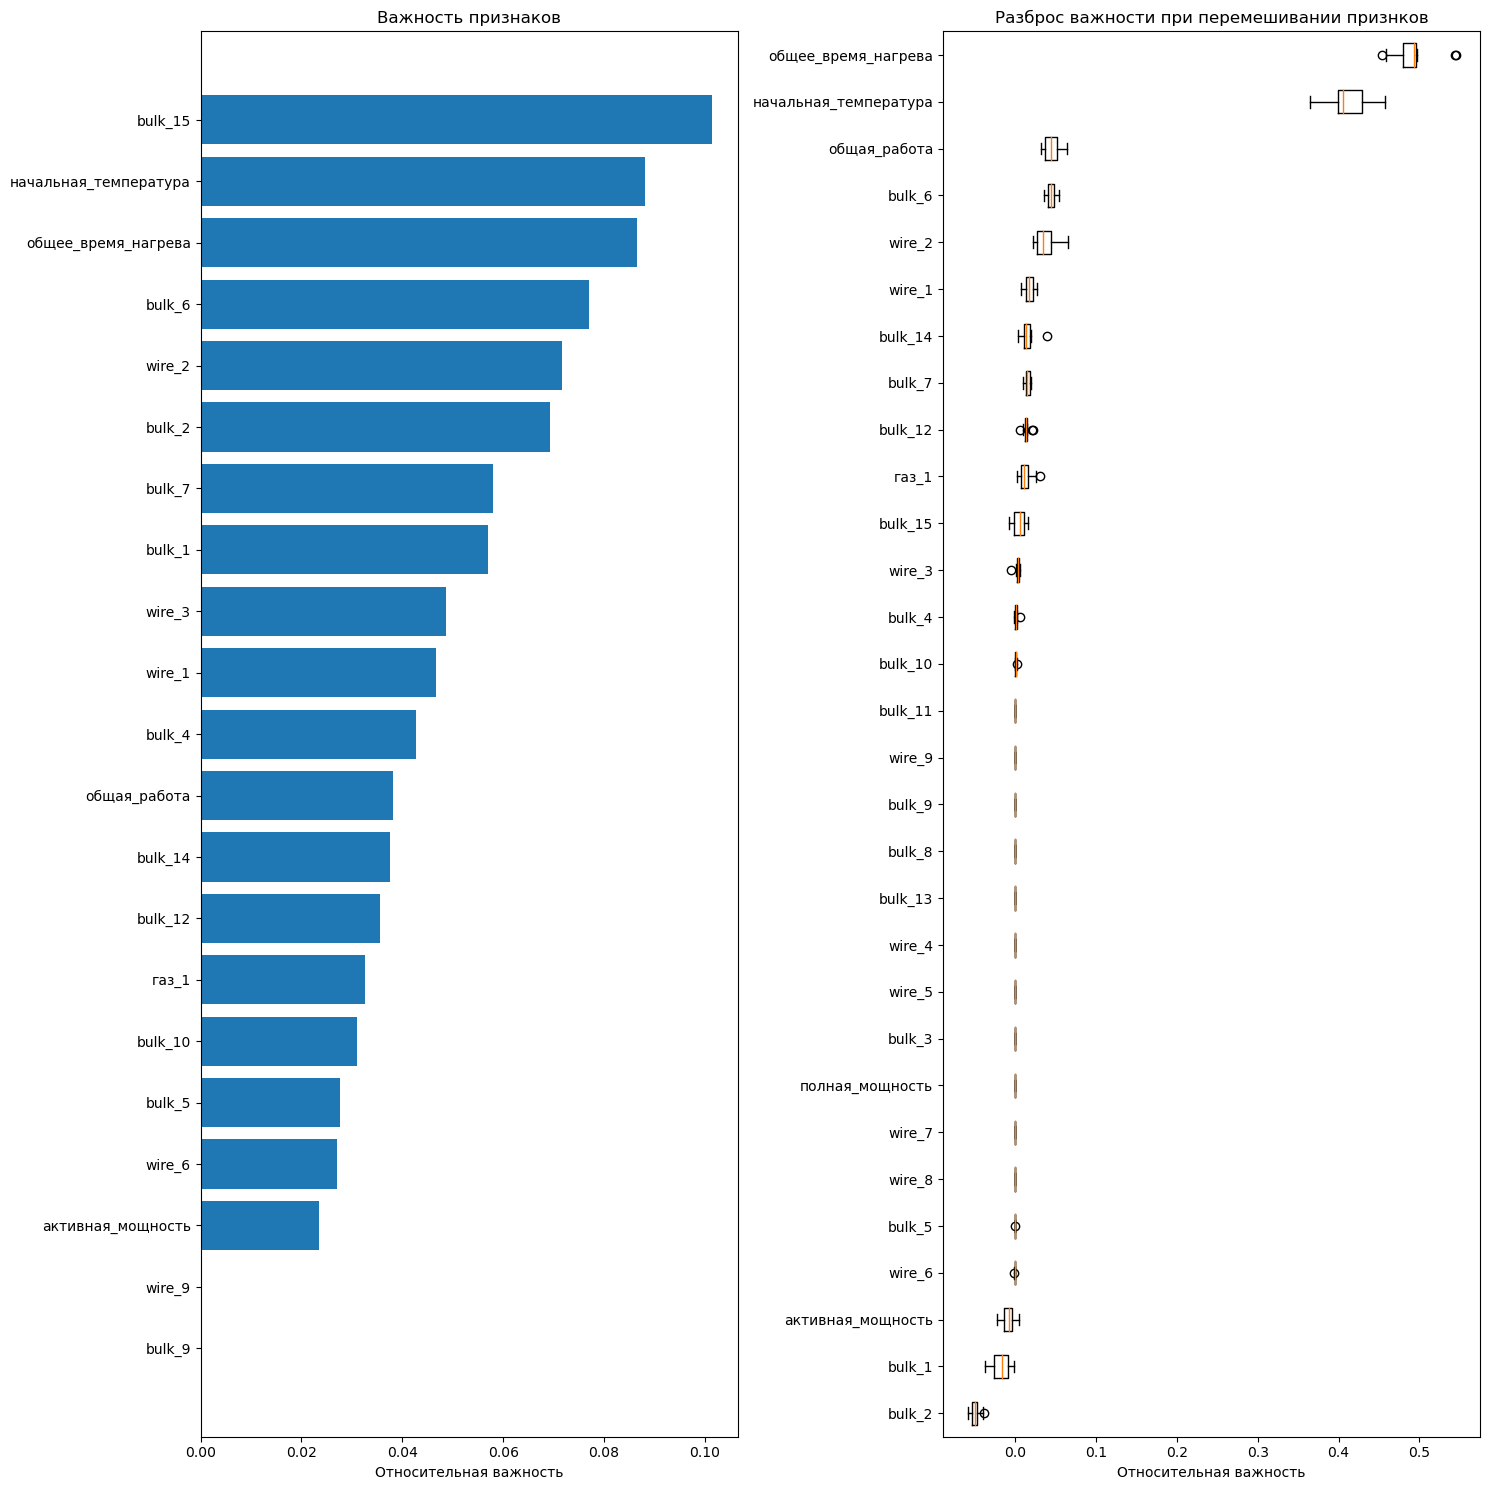

In [77]:
features = grid.best_estimator_[0].get_feature_names_out()[grid.best_estimator_[-2].get_support()]
importances = grid.best_estimator_.named_steps['clf'].feature_importances_
sorted_index = np.argsort(importances)
pos = np.arange(sorted_index.shape[0])

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, importances[sorted_index], align="center")
plt.yticks(pos, np.array(features)[sorted_index])
plt.title("Важность признаков")
plt.xlabel('Относительная важность')


result = permutation_importance(
    grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=7, n_jobs=-1
)
sorted_index = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_index].T,
    vert=False,
    labels=X_test.columns[sorted_index],
)
plt.title('Разброс важности при перемешивании признков')
plt.xlabel('Относительная важность')
fig.tight_layout()
plt.show()

Видно что после при перемешивании признаков важность признаков сортируется немного в другом порядке. Также есть признаки у которых при перемешивании снижается коэффициент.

## Отчет по работе

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?  
   В ходе работы выполнены все этапы.  
2. Какие трудности возникли и как вы их преодолели?  
   Самый сложный этап - понимание что у меня была старая версия sklearn).
3. Какие ключевые шаги в решении задачи выделили?  
   Все как в заголовках проекта. 
   - Анализ данных 
   - Понимание что хочет заказчик и как нам этого добиться 
   - Еще раз анализ и построение предобработки 
   - Подготовка данных для модели
   - Нахождение лучшей модели
   - Анализ результатов
   - Выводы которые мы можем сделать для для заказчика на основании модели и анализа данных  
   
4. Какая ваша итоговая модель и какое у неё качество?
   - XGBRegressor, средняя абсолютная ошибка (MAE) на тестовой выборке 5.86.
   
`Список признаков` (после DropCorrelatedFeatures и SelectKBest в pipeline). Всего 21 признак:  
  - ['активная_мощность', 'общая_работа', 'общее_время_нагрева',
       'газ_1', 'bulk_1', 'bulk_2', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_12', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9',
       'начальная_температура']
  
`Лучшие гиперпараметры` модели (пайплайна):  
   - XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=4, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=200, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=240423, ...)


## Вывод

  1. Анализ данных  
    - Были выявлены аномалии в реактивной мощности, температуре, пропуски в данных
    - Замечены высококоррелирующие признаки
    - Изменены типы данных
  2. Предобработка и подготовка данных для модели
    - Критичные для прогноза пропуски а также аномалии в данных удалены
    - Построен конвеер для последовательной подготовки данных для модели. Так как в данных используются только количественные числовые значения, в него вошли такие методы как замена оставшихся пропусков SimpleImputer, стандартизация данных MaxAbsScaler, удаление высоко коррелирующих признаков DropCorrelatedFeatures, удаление дубликатов DropDuplicateFeatures, а также выбор наилучших k признаков после серии статистических тестов SelectKBest.
  3. Нахождение лучшей модели
    - В конвеере также реализован метод подбора лучшей модели и ее гиперпараметров.
  4. Анализ результатов
    - Лучшей моделью стала XGBRegressor
    - Cредняя абсолютная ошибка (MAE) 5.88. Это значит что модель на данном этапе и на представленных данных предсказывает со средней ошибкой в 5.9 градусов. Наша модель лучше случайной модели (предсказывающей средним значением). У такой  модели средняя ошибка 8.2 градуса.
    - Наиболее важными гиперпараметрами для модели стали 'начальная_температура', 'общее_время_нагрева', 'общая_работа', 'bulk_6'.  
      Признаки 'общее_время_нагрева', 'общая_работа' синтетические. В них присутствует параметр времени.
    - Для улучшения модели возможно более детальное добавление применение признаков имеющих эффект времени. Также возможно применение дополнительных моделей для прогнозирования исходного состава металла и количества присадок для получения кондиции.
    - Данная модель позволит с большей точностью спрогнозировать финальную температуру, и более экономично выстроить тех процесс производства.
